In [53]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.pyplot as plt
import mapclassify as mc
import matplotlib.patches as mpatches
import libpysal as ps
import esda
import matplotlib.pyplot as plt
import os

In [54]:
怎么的导出导入的

NameError: name '怎么的导出导入的' is not defined

In [59]:
# loading cleaning csv
df = pd.read_csv("data/listings.csv")

# create GeoDataFrame the geographic coordinate reference system is WGS84 (EPSG:4326)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# save as a Parquet file
geo_df.to_parquet("airbnb_listings_wgs84.parquet", index=False)

In [65]:
import geopandas as gpd

shp_path = "london_poi_all/london-latest.shp"
gdf = gpd.read_file(shp_path)
if gdf.crs is None:
    gdf = gdf.set_crs("EPSG:4326")
else:
    gdf = gdf.to_crs("EPSG:4326")

londonacc_t_gdf = gdf[gdf['category'] == 'ACCOMMODATION']
london_hotel_gdf = londonacc_t_gdf[londonacc_t_gdf['subcategor'] == 'HOTEL']
output_path = "hotel_point.parquet"
london_hotel_gdf.to_parquet(output_path, index=False)
london_hotel_gdf = gpd.read_parquet(output_path)

原始数据的坐标系: EPSG:4326
筛选后数据的坐标系: EPSG:4326
File has been saved to hotel_point.parquet
              id                                             name  \
0  node/25947730                                          Novotel   
1  node/26197001                                     Crowne Plaza   
2  node/29372721          Sundridge Park hotel and conference Ctr   
3  node/31314241  DoubleTree by Hilton Hotel London - Marble Arch   
4  node/59931333                               easyHotel Victoria   

        category subcategor       lon        lat  srid  \
0  ACCOMMODATION      HOTEL -0.455853  51.497544  4326   
1  ACCOMMODATION      HOTEL -0.454210  51.499441  4326   
2  ACCOMMODATION      HOTEL  0.037226  51.417030  4326   
3  ACCOMMODATION      HOTEL -0.156638  51.514571  4326   
4  ACCOMMODATION      HOTEL -0.142005  51.491988  4326   

                                     wkt    city image  ... housenumbe   fax  \
0          POINT (-0.4558534 51.4975442)    None  None  ...       None  

In [68]:
#Loading data  
ddir = os.path.join('data')
file_path = os.path.join(ddir, 'greater_london.gpkg')  #full path

# loading GPKG
msoa_boundaries = gpd.read_file(file_path)

airbnb_gdf = gpd.read_parquet("airbnb_listings_wgs84.parquet")

In [69]:
hotel_gdf = gpd.read_parquet("hotel_point.parquet")

In [70]:
#Change the point to a projected coordinate system
airbnb_gdf = airbnb_gdf.to_crs('epsg:27700') # There is no 'in_place=True' option here.
hotel_gdf = hotel_gdf.to_crs('epsg:27700') # There is no 'in_place=True' option here.

In [71]:
#join the data  
# using spatial join to link Airbnb points to MSOA regions
airbnb_with_msoa = gpd.sjoin(airbnb_gdf, msoa_boundaries, how="inner", predicate='within')

# Counting the number of Airbnb points in each MSOA area
airbnb_count = airbnb_with_msoa.groupby('geo_code').size().reset_index(name='airbnb_count')

msoa_boundaries['area_m2'] = msoa_boundaries.geometry.area
msoa_boundaries['area_h'] = msoa_boundaries.geometry.area / 10000
# merge data
msoa_with_airbnb = msoa_boundaries.merge(airbnb_count, on='geo_code', how='left')

#nan=0
msoa_with_airbnb['airbnb_count'] = msoa_with_airbnb['airbnb_count'].fillna(0)

msoa_with_airbnb['density'] = msoa_with_airbnb['airbnb_count'] / msoa_with_airbnb['area_h']


In [72]:
# Standardised formula：Min-Max Scaling
def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.min())


msoa_with_airbnb['nairbnb_count'] = min_max_scaling(msoa_with_airbnb['airbnb_count'])
msoa_with_airbnb['n_density'] = min_max_scaling(msoa_with_airbnb['density'])

In [73]:
#Join hotel data
hotels_with_msoa = gpd.sjoin(hotel_gdf, msoa_with_airbnb, how="inner", predicate="within")
hotel_count = hotels_with_msoa.groupby('geo_code').size().reset_index(name='hotel_count')
msoa_with_airbnb_hotels = msoa_with_airbnb.merge(hotel_count, on='geo_code', how='left')
msoa_with_airbnb_hotels['hotel_count'] = msoa_with_airbnb_hotels['hotel_count'].fillna(0)
msoa_with_airbnb_hotels['hotel_density'] = msoa_with_airbnb_hotels['hotel_count'] / msoa_with_airbnb_hotels['area_h']


In [74]:
# Standardised formula：Min-Max Scaling
def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.min())


msoa_with_airbnb_hotels['nhotel_count'] = min_max_scaling(msoa_with_airbnb_hotels['hotel_count'])
msoa_with_airbnb_hotels['nhotel_density'] = min_max_scaling(msoa_with_airbnb_hotels['hotel_density'])

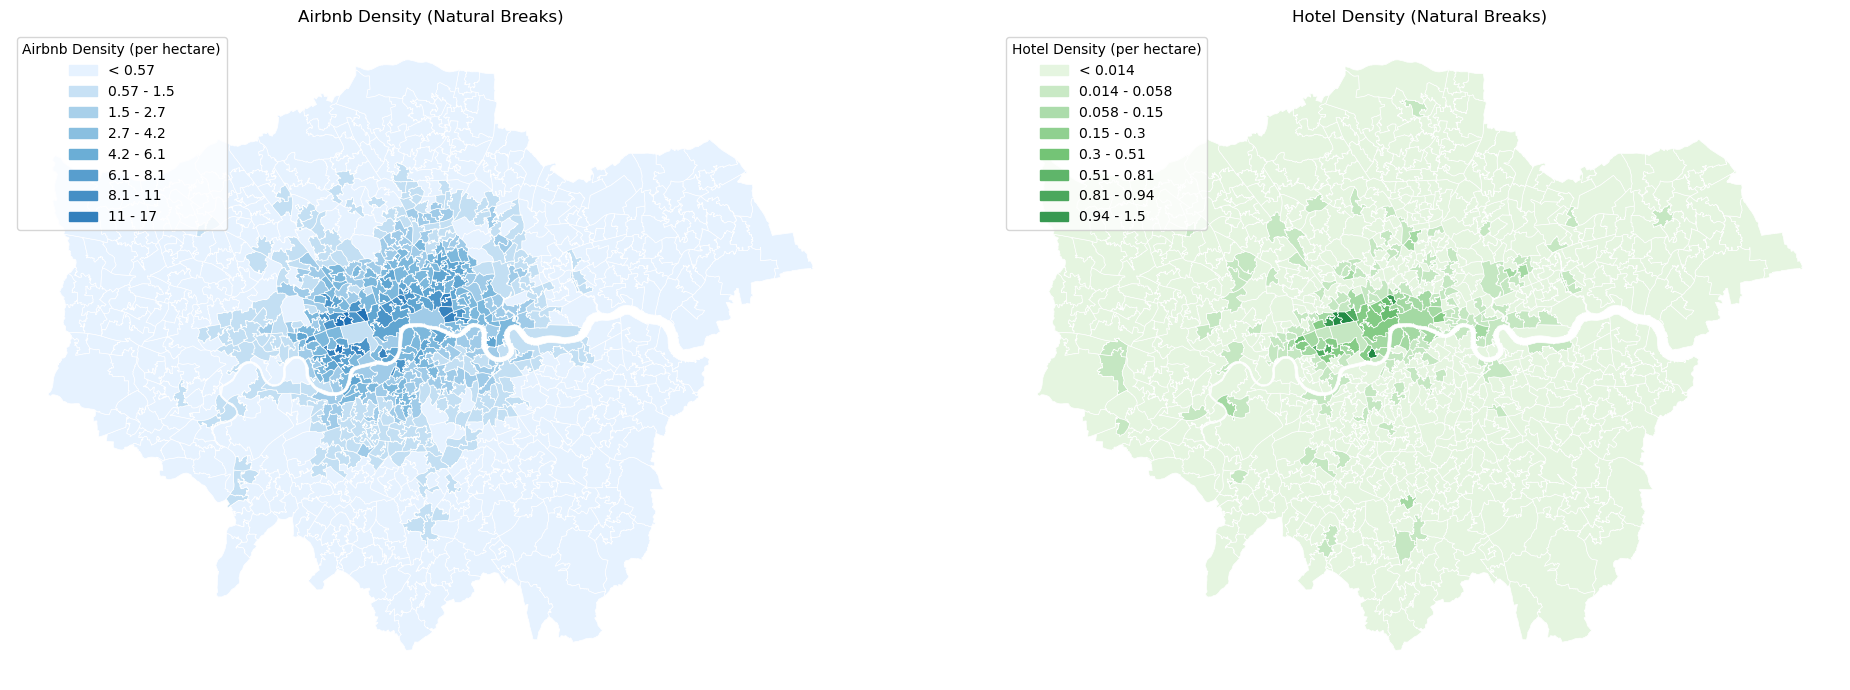

In [75]:
import matplotlib.pyplot as plt
import mapclassify as mc
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

blues_custom = LinearSegmentedColormap.from_list("custom_blues", ['#E6F2FF', '#6BAED6', '#2171B5'], N=256)
greens_custom = LinearSegmentedColormap.from_list("custom_greens", ['#E5F5E0', '#74C476', '#238B45'], N=256)


def custom_legend(scheme, cmap, title):
    bins = scheme.bins
    labels = [f"{format(bins[i-1], '.2g')} - {format(bins[i], '.2g')}" for i in range(1, len(bins))]
    labels.insert(0, f"< {format(bins[0], '.2g')}")
    colors = [cmap(i / len(labels)) for i in range(len(labels))]
    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
    return patches

# Airbnb density (Natural Breaks)
scheme_density = mc.NaturalBreaks(msoa_with_airbnb_hotels['density'], k=8)
msoa_with_airbnb_hotels.plot(
    column='density',
    cmap=blues_custom,
    legend=False,
    linewidth=0.5,
    edgecolor='white',
    scheme='natural_breaks',
    classification_kwds={'k': 8},
    ax=axes[0]
)
axes[0].set_title("Airbnb Density (Natural Breaks)")
axes[0].set_axis_off()

airbnb_legend = custom_legend(scheme_density, blues_custom, "Airbnb Density (per hectare)")
axes[0].legend(handles=airbnb_legend, title="Airbnb Density (per hectare)", loc="upper left")

# Hotel density (Natural Breaks)
scheme_hotel_density = mc.NaturalBreaks(msoa_with_airbnb_hotels['hotel_density'], k=8)
msoa_with_airbnb_hotels.plot(
    column='hotel_density',
    cmap=greens_custom,
    legend=False,
    linewidth=0.5,
    edgecolor='white',
    scheme='natural_breaks',
    classification_kwds={'k': 8},
    ax=axes[1]
)
axes[1].set_title("Hotel Density (Natural Breaks)")
axes[1].set_axis_off()


hotel_legend = custom_legend(scheme_hotel_density, greens_custom, "Hotel Density (per hectare)")
axes[1].legend(handles=hotel_legend, title="Hotel Density (per hectare)", loc="upper left")

# layout
plt.tight_layout()
plt.show()

A comparison of the density plots reveals that airbnb is more widespread distribution, the high density area is in and around Central London’s tourist region (like West End, River Thames route, South Bank, etc.) Airbnb also has the trend on spreading to outer residential areas, (like Islington, Hackney, etc.). Reveal the strong market penetration and flexibility. Hotels are more centrally located, Rely heavily on the commercial and tourist hotspots in the core, particularly along the Thames, the City of London and Oxford Street. In the outlying regions the hotel's distribution is almost blank, showing its market limitations, so Airbnb has the potential to fill that gap.


In [12]:
import libpysal as ps
import esda
import geopandas as gpd
import matplotlib.pyplot as plt

In [23]:
tdf = pd.read_csv("data/london_tourism_area.csv")

In [24]:
tdf['MSOA11CD'] = tdf['MSOA11CD'].astype(str)  #turn both type to str
msoa_with_airbnb_hotels['geo_code'] = msoa_with_airbnb_hotels['geo_code'].astype(str)

# join the data together
msoa_with_airbnb_hotels = msoa_with_airbnb_hotels.merge(
    tdf,
    left_on='geo_code',        # msoa_with_airbnb_hotels 中的列
    right_on='MSOA11CD',     # tdfcolumnc
    how='left'               # left join
)

# 如果需要删除重复的列
msoa_with_airbnb_hotels = msoa_with_airbnb_hotels.drop(columns=['MSOA11CD'])

#tradtional area and non_traditional_area
traditional_area = msoa_with_airbnb_hotels[msoa_with_airbnb_hotels['hotspot_binary'] == 1]
non_traditional_area = msoa_with_airbnb_hotels[msoa_with_airbnb_hotels['hotspot_binary'] == 0]

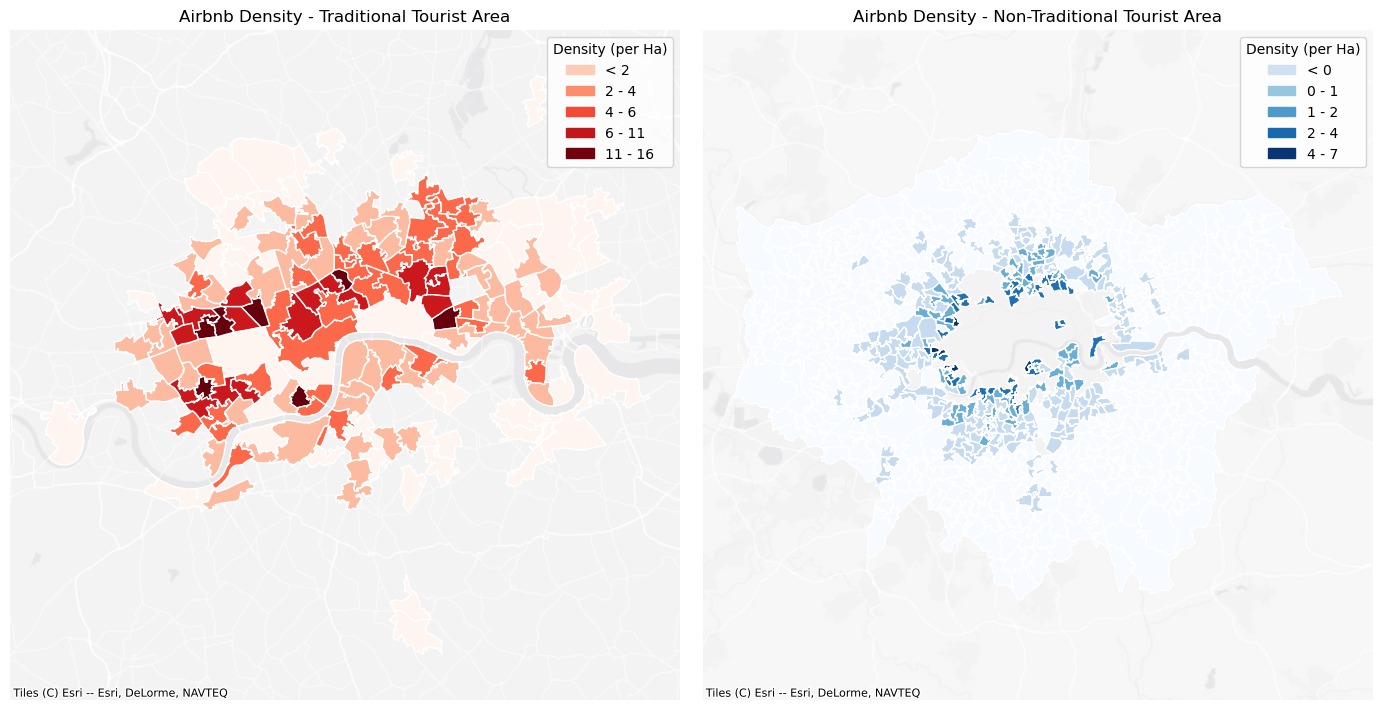

In [44]:
import matplotlib.pyplot as plt
import contextily as ctx
import mapclassify as mc
import matplotlib.patches as mpatches


scheme_traditional = mc.NaturalBreaks(traditional_area['density'], k=5)  # 使用5个断点为示例
scheme_non_traditional = mc.NaturalBreaks(non_traditional_area['density'], k=5)

fig, ax = plt.subplots(1, 2, figsize=(14, 7))


box_aspect_ratio = 1

# Traditional tourist areas
ax[0].set_box_aspect(box_aspect_ratio)
traditional_area.plot(
    column='density',
    cmap='Reds',
    edgecolor='white',
    scheme='natural_breaks',
    classification_kwds={'k': 5},
    legend=False,
    ax=ax[0]
)
ctx.add_basemap(ax[0], source=ctx.providers.Esri.WorldGrayCanvas, crs=traditional_area.crs, alpha=0.5)
ax[0].set_title("Airbnb Density - Traditional Tourist Area", fontsize=12)
ax[0].axis("off")

bins_traditional = scheme_traditional.bins
labels_traditional = [f"{int(bins_traditional[i-1])} - {int(bins_traditional[i])}" for i in range(1, len(bins_traditional))]
labels_traditional.insert(0, f"< {int(bins_traditional[0])}")
colors_traditional = plt.cm.Reds(range(50, 256, 50))


patches_traditional = [mpatches.Patch(color=colors_traditional[i], label=labels_traditional[i]) for i in range(len(labels_traditional))]
ax[0].legend(handles=patches_traditional, title="Density (per Ha)")

# Non-traditional tourist areas
ax[1].set_box_aspect(box_aspect_ratio)
non_traditional_area.plot(
    column='density',
    cmap='Blues',
    edgecolor='white',
    scheme='natural_breaks',
    classification_kwds={'k': 5},
    legend=False,
    ax=ax[1]
)
ctx.add_basemap(ax[1], source=ctx.providers.Esri.WorldGrayCanvas, crs=non_traditional_area.crs, alpha=0.5)
ax[1].set_title("Airbnb Density - Non-Traditional Tourist Area", fontsize=12)
ax[1].axis("off")

bins_non_traditional = scheme_non_traditional.bins
labels_non_traditional = [f"{int(bins_non_traditional[i-1])} - {int(bins_non_traditional[i])}" for i in range(1, len(bins_non_traditional))]
labels_non_traditional.insert(0, f"< {int(bins_non_traditional[0])}")
colors_non_traditional = plt.cm.Blues(range(50, 256, 50))

# label
patches_non_traditional = [mpatches.Patch(color=colors_non_traditional[i], label=labels_non_traditional[i]) for i in range(len(labels_non_traditional))]
ax[1].legend(handles=patches_non_traditional, title="Density (per Ha)")

# layout
plt.tight_layout()
plt.show()

Airbnb has a clear spatial-functional gradient in the London market, in traditional tourism areas, Airbnb is centrally distributed and nearly overlaps with major attractions and commercial areas, in non-traditional tourism areas, distribution does not form a hotspot area, Demonstrating initial market development and demand for short-term rentals has yet to be effectively activated. So, the future growth of Airbnb should focus on improving the appeal of these non-traditional areas to drive expansion and spatial rebalancing of the short-term rental market.